In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm_notebook
import cv2
import torch.utils.data
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms, datasets
import torchvision.models as models
import re

import torch.nn as nn
from typing import Optional
import albumentations as A
import random
import os.path as p

import torch

#from tfrecord.torch.dataset import TFRecordDataset
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import librosa
import librosa.display
import IPython.display as ipd
import soundfile as sf
import os
from IPython.core.debugger import set_trace
from IPython.core.debugger import Tracer
from PIL import Image
import _pickle as cPickle
import torch.nn.functional as F
import skimage.transform
import math
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift,Gain,\
                            AddGaussianSNR, AddImpulseResponse, AddShortNoises,\
                            FrequencyMask, PitchShift, Shift, TimeMask, TimeStretch
import albumentations as A
from torch.distributions.beta import Beta
%load_ext line_profiler

In [2]:
#!pip install iterative-stratification
#!pip3 install opencv-python
#!pip install ipywidgets
#conda install -c anaconda line_profiler

In [3]:
WIN=False
PATH ="..\\..\\..\\data\\rf\\rfcx-species-audio-detection" if WIN else "../../../data/rf"
TRAIN_FP_PATH = p.join(PATH,"train_fp.csv")
TRAIN_TP_PATH = p.join(PATH,"train_tp.csv")
SS_PATH = p.join(PATH, "sample_submission.csv")
TF_RECORDS_TRAIN_PATH = p.join(PATH, "tfrecords\\train")
TF_RECORDS_TEST_PATH = p.join(PATH, "tfrecords\\test")
TRAIN_PATH = p.join(PATH, "train")
TEST_PATH = p.join(PATH, "test")
TRAIN_SPEC_PATH = p.join(PATH, "train_spec")
TEST_SPEC_PATH = p.join(PATH, "test_spec")
MODELS_PATH = p.join(PATH, "models")
CLASS_NUM = 24
CLASS_NUM_EXT = CLASS_NUM# + 2

FOLDS_NUM = 8
BS=8
CYCLES = FOLDS_NUM * 1
IMG_SIZE=224
POWERS = [2,2.2,2.5]#[1.5,1.7,2,2.2,2.5,2.7,3]


LEN=20
EXT=5
VSTEPS=5
VSHIFT=10

#LEN=10
#EXT=2
#VSTEPS=6
#VSHIFT=10

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

In [4]:
tp_df = pd.read_csv(TRAIN_TP_PATH)
fp_df = pd.read_csv(TRAIN_FP_PATH)
ss_df = pd.read_csv(SS_PATH)
#don't count song_type
S_COL_NAMES = ['s' + str(i) for i in range(CLASS_NUM_EXT)]
train_df = pd.DataFrame(columns=['recording_id'] + S_COL_NAMES)
tp_rec_ids = list(set(tp_df['recording_id'].values))
tp_rec_ids.sort()
train_df['recording_id'] = tp_rec_ids
train_df[S_COL_NAMES] = 0

for i in range(CLASS_NUM):
    
    if (i !=175 and i != 234):
        recording_ids = tp_df.loc[tp_df['species_id']==i]['recording_id']
        indexes = train_df[train_df['recording_id'].isin(recording_ids)].index 
        #print(indexes)
        train_df.loc[indexes,'s' + str(i)] = 1 
    else:
        #Tracer()()
        recording_ids1 = tp_df.loc[(tp_df['species_id']==i) & (tp_df['songtype_id']==1)]['recording_id']
        recording_ids2 = tp_df.loc[(tp_df['species_id']==i) & (tp_df['songtype_id']==4)]['recording_id']
        indexes1 = train_df[train_df['recording_id'].isin(recording_ids1)].index 
        indexes2 = train_df[train_df['recording_id'].isin(recording_ids2)].index 
        train_df.loc[indexes1,'s' + str(i)] = 1
        num = 24 if i == 17 else 25
        train_df.loc[indexes2,'s' + str(num)] = 1

#16,17, 23 have songtype_id==4    
 

In [5]:
'''s1 = set(tp_df['recording_id'].values)
s2 = set(fp_df[fp_df['species_id']==3]['recording_id'].values)
s1ands2 = s1.intersection(s2)
s2diffs1 = s2.difference(s1)

train_df_inc = pd.DataFrame(columns=['recording_id'] + S_COL_NAMES)
tmp = list(s2diffs1)
tmp.sort()
train_df_inc['recording_id'] = tmp
train_df_inc[S_COL_NAMES] = 0
train_df_inc['s9']=0.5
train_df_inc['s10']=0.5
print(len(train_df))
#train_df = pd.concat([train_df, train_df_inc], ignore_index=True)
print(len(train_df))
#recording_ids = tp_df.loc[tp_df['species_id']==i]['recording_id']
indexes = train_df[train_df['recording_id'].isin(s1ands2)].index 
        #print(indexes)
train_df.loc[indexes,'s9'] = 0.5
#train_df.loc[indexes,'s10'] = 0.5
print(len(train_df)), len (s1ands2)'''

"s1 = set(tp_df['recording_id'].values)\ns2 = set(fp_df[fp_df['species_id']==3]['recording_id'].values)\ns1ands2 = s1.intersection(s2)\ns2diffs1 = s2.difference(s1)\n\ntrain_df_inc = pd.DataFrame(columns=['recording_id'] + S_COL_NAMES)\ntmp = list(s2diffs1)\ntmp.sort()\ntrain_df_inc['recording_id'] = tmp\ntrain_df_inc[S_COL_NAMES] = 0\ntrain_df_inc['s9']=0.5\ntrain_df_inc['s10']=0.5\nprint(len(train_df))\n#train_df = pd.concat([train_df, train_df_inc], ignore_index=True)\nprint(len(train_df))\n#recording_ids = tp_df.loc[tp_df['species_id']==i]['recording_id']\nindexes = train_df[train_df['recording_id'].isin(s1ands2)].index \n        #print(indexes)\ntrain_df.loc[indexes,'s9'] = 0.5\n#train_df.loc[indexes,'s10'] = 0.5\nprint(len(train_df)), len (s1ands2)"

In [6]:
train_df

,recording_id,s0,s1,s2,s3,s4,s5,s6,s7,s8,...,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23
0,003bec244,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,006ab765f,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,007f87ba2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0099c367b,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,009b760e6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1127,fe8d9ac40,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1128,fea6b438a,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1129,ff2eb9ce5,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1130,ffb8d8391,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
#tp_df.groupby(['species_id','songtype_id']).count(),train_df.ne(0).sum()
s1 = set(tp_df['recording_id'].values)
s2 = set(fp_df['recording_id'].values)
len(s1.intersection(s2)), len(s1), len(s2)
s1.intersection(s2)
tp_df[tp_df['recording_id']=='0209f7ab2'],fp_df[fp_df['recording_id']=='0209f7ab2']

(   recording_id  species_id  songtype_id    t_min   f_min    t_max    f_max
 12    0209f7ab2           7            1  50.7573  4687.5  53.8987  11437.5,
    recording_id  species_id  songtype_id   t_min    f_min   t_max   f_max
 52    0209f7ab2           3            1  8.0213  1031.25  8.7627  2812.5)

In [8]:
tp_df[tp_df['species_id']==3]#2 12 19
tp_df[(tp_df['f_min']>800) & (tp_df['f_min']<3100) & (tp_df['f_min']<1200) & (tp_df['f_max']>2400)].groupby(['species_id']).count()


,recording_id,songtype_id,t_min,f_min,t_max,f_max
species_id,,,,,,
3,50,50,50,50,50,50
9,34,34,34,34,34,34
10,50,50,50,50,50,50


In [9]:
df = train_df.sample(frac=1.,random_state=2020)


df['kfold'] = -1
kf = MultilabelStratifiedKFold(n_splits=FOLDS_NUM, random_state=2021)
y = df[S_COL_NAMES].values
for fold, (t_,v_) in enumerate(kf.split(X=df,y=y)):
    df.loc[v_,'kfold'] = fold
    

/home/paperspace/anaconda3/envs/new_env/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass shuffle=False, random_state=2021 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/home/paperspace/anaconda3/envs/new_env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [10]:
df

,recording_id,s0,s1,s2,s3,s4,s5,s6,s7,s8,...,s15,s16,s17,s18,s19,s20,s21,s22,s23,kfold
830,bbd6815be,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
58,0e034f968,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
697,9cccd9345,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
386,5673135ca,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
710,9f8fcb625,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,226ce47d9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2
91,1504619b7,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,7
630,8a0ee2e2c,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2
392,579bcf9e0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
def get_start_end(time, duration, total_samples=5626, bound=False, strong=False):
    start, end = 0,0
    
    min = 3
    lim=60
    if strong:
        start = time
    elif (not bound):
        start = random.randint(0, lim - duration)
    elif (time <= min):
        start = 0
    elif (time + 3 >= lim):
        start = lim - duration    
    else:
        start = random.randint(max(time+3 - duration, 0), time-3)
    sec = total_samples/60
    end = start + duration
    #print(start, end, sec, int(start * sec), int(end * sec))
    return int(start * sec), int(end * sec)

for i in range(15):
    get_start_end(20, 20, bound=True)


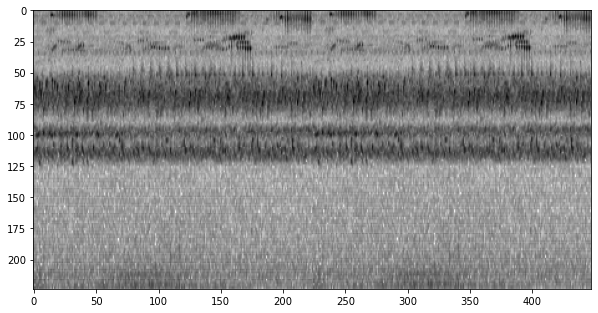

In [12]:
audio_augments = Compose([
    #AddGaussianNoise( p=0.7),
     #TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),   
    #Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5),    
    Gain(min_gain_in_db=-12, max_gain_in_db=12, p=0.5),
    #AddGaussianSNR(min_SNR=0.001, max_SNR=1.0, p=0.5),
    
    #???FrequencyMask(min_frequency_band=0.9, max_frequency_band=0.999, p=1)
    #???FrequencyMask(min_frequency_band=0.8, max_frequency_band=0.81, p=1)
    #PitchShift(min_semitones=-4, max_semitones=4, p=0.0),
    #TimeMask(min_band_part=0.5, max_band_part=0.5, fade=False, p=1)
])
image_aug = A.Compose([      
    A.RandomBrightnessContrast(p=0.7),    
    #A.Cutout(num_holes=10,fill_value=0.4,p=0.3)#???
])


def get_file_data(name, dir_name, audio_aug):
    file_name = p.join(dir_name, name + '.flac')    
    data, samplerate = sf.read(file_name)    
    if (audio_aug):
        data = audio_augments(samples=data, sample_rate=samplerate)
    return data, samplerate 
def get_spectrogram(name, dir_name=TRAIN_PATH, audio_aug=False):
    #data = get_file_data(name, dir_name, audio_aug)
    #X = librosa.stft(data,n_fft=2048,hop_length=512)
    #return  librosa.amplitude_to_db(abs(X))
    
    data, samplerate = get_file_data(name, dir_name, audio_aug)
    
    power = POWERS[random.randint(0, len(POWERS) - 1)] if audio_aug else 2
    mel_spectrogram = librosa.feature.melspectrogram(data, sr=samplerate, 
                                                     n_fft=2048, hop_length=512, n_mels=300, power=power)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
    return log_mel_spectrogram

def scale_minmax(X, min=0.0, max=1.0):
    X_std = 1 -  (X - X.min()) / (X.max() - X.min())
    #Tracer()()
    X_scaled = X_std * (max - min) + min
    return X_scaled



def prepare_img(img, time, duration, bound, strong):
    
    #1025 5626
    start, end =get_start_end(time=time, duration=duration, bound=bound, strong=strong)
    #out=img[:600,start:end]
    
    
    out=img[:190,start:end] #<-mel
    out = np.flip(out, axis=0)
    
    out = cv2.resize(out,(IMG_SIZE, 2*IMG_SIZE))
    out = np.reshape(out, (IMG_SIZE, 2*IMG_SIZE, -1))
    out  = np.repeat(out, 3, 2) 
    #Tracer()()
    out = scale_minmax(out).astype(np.float32)
    #out = 255-out
    
    return out



def save_specs():
    save_spec(TRAIN_PATH, TRAIN_SPEC_PATH)
    #Tracer()()
    save_spec(TEST_PATH, TEST_SPEC_PATH)

def save_spec(source_dir, dest_dir):
    names_list = os.listdir(source_dir)
    pbar = tqdm_notebook(total = len(names_list))
    for fname in names_list:
        fid = fname[:-5]
        img = get_spectrogram(fid, source_dir)
        #img = prepare_img(img)        
        #img = Image.fromarray(img)
        #img.save(p.join(TEST_SPEC_PATH, fid + '.png'))
        with open(p.join(dest_dir, fid + '.pickle'), "wb") as output_file:
            cPickle.dump(img, output_file)
        pbar.update(1)
    pbar.close()

    
def get_spec_bytes(rec_id, spec_path = TRAIN_SPEC_PATH, from_file=False, 
                   time = time, duration=60, sd = None, bound=False,
                   audio_aug = False, strong=False):
    if (from_file):
        with open(p.join(spec_path, rec_id + '.pickle'), "rb") as output_file:
            result = cPickle.load(output_file) 
    else:
        result = get_spectrogram(rec_id, sd, audio_aug)
    #result = Image.open(p.join(spec_path, rec_id + '.png'))
    #result = np.array(result.getdata()).reshape(IMG_SIZE, IMG_SIZE, 3).astype(np.uint8)
    result = prepare_img(result, time = time, duration = duration, bound=bound, strong=strong)
    return result


plt.figure(figsize=(10, 10))
plt.imshow(get_spec_bytes('9e52cf6ad', time=20, duration=20, sd=TRAIN_PATH,bound = False))



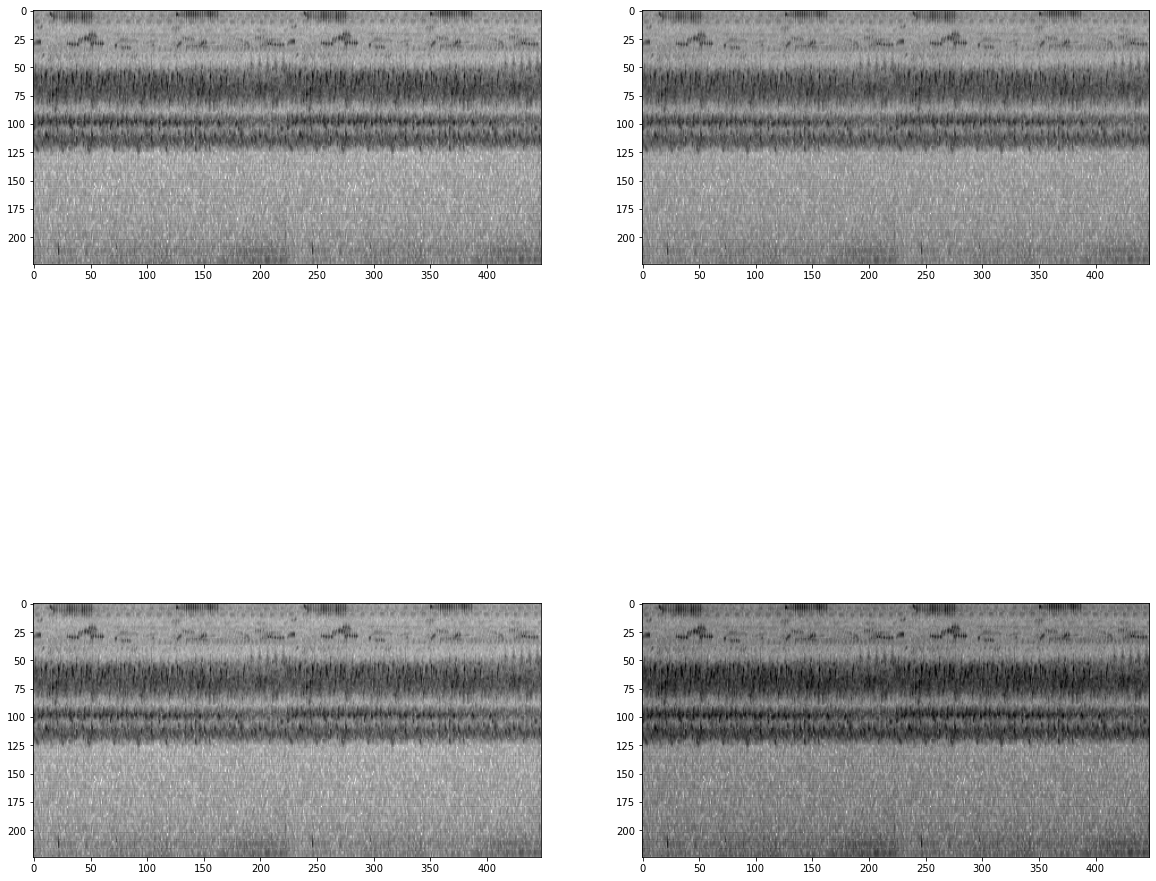

[[[0.42473865 0.42473865 0.42473865]
  [0.39770016 0.39770016 0.39770016]
  [0.49600667 0.49600667 0.49600667]
  ...
  [0.5494852  0.5494852  0.5494852 ]
  [0.44316888 0.44316888 0.44316888]
  [0.43082446 0.43082446 0.43082446]]

 [[0.45916957 0.45916957 0.45916957]
  [0.45561576 0.45561576 0.45561576]
  [0.52155703 0.52155703 0.52155703]
  ...
  [0.57802397 0.57802397 0.57802397]
  [0.44429308 0.44429308 0.44429308]
  [0.44144958 0.44144958 0.44144958]]

 [[0.51285475 0.51285475 0.51285475]
  [0.51662594 0.51662594 0.51662594]
  [0.5285624  0.5285624  0.5285624 ]
  ...
  [0.51443946 0.51443946 0.51443946]
  [0.4680521  0.4680521  0.4680521 ]
  [0.48159623 0.48159623 0.48159623]]

 ...

 [[0.3615064  0.3615064  0.3615064 ]
  [0.42908883 0.42908883 0.42908883]
  [0.45301867 0.45301867 0.45301867]
  ...
  [0.31085312 0.31085312 0.31085312]
  [0.34126982 0.34126982 0.34126982]
  [0.29469883 0.29469883 0.29469883]]

 [[0.36941746 0.36941746 0.36941746]
  [0.39882573 0.39882573 0.39882573]


In [13]:




import matplotlib.pyplot as plt


fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(20, 20))

img = get_spec_bytes('9e52cf6ad', time=20, duration=20, sd = TRAIN_PATH,bound = False)
#img = 1-img
i = 0

for row in ax:
    for col in row:
        if (i == 0):
            col.imshow(img)
        else:  
            
            t = image_aug(image=(img))  
            
            col.imshow(np.float64(t['image']))
        i +=1
plt.show()
print(t['image'])
#def albumentations.augmentations.functional.add_fog(img, fog_coef, alpha_coef, haze_list)
#def albumentations.augmentations.functional.add_rain(img, slant, drop_length, drop_width, drop_color, blur_value, brightness_coefficient, rain_drops) [view source on GitHub] ¶
#class albumentations.augmentations.transforms.Blur (blur_limit=7, always_apply=False, p=0.5) 
#class albumentations.augmentations.transforms.CoarseDropout (max_holes=8, max_height=8, max_width=8, min_holes=None, min_height=None, min_width=None, fill_value=0, mask_fill_value=None, always_apply=False, p=0.5)
#class albumentations.augmentations.transforms.ColorJitter (brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5)
#class albumentations.augmentations.transforms.Cutout (num_ho1les=8, max_h_size=8, max_w_size=8, fill_value=0, always_apply=False, p=0.5) [view source on GitHub] ¶
#class albumenta1tions.augmentations.transforms.Downscale (scale_min=0.25, scale_max=0.25, interpolation=0, always_apply=False, p=0.5) [view source on GitHub] ¶



In [14]:
img

array([[[0.5241104 , 0.5241104 , 0.5241104 ],
        [0.4965112 , 0.4965112 , 0.4965112 ],
        [0.59685636, 0.59685636, 0.59685636],
        ...,
        [0.6514439 , 0.6514439 , 0.6514439 ],
        [0.5429228 , 0.5429228 , 0.5429228 ],
        [0.5303224 , 0.5303224 , 0.5303224 ]],

       [[0.5592553 , 0.5592553 , 0.5592553 ],
        [0.5556278 , 0.5556278 , 0.5556278 ],
        [0.62293655, 0.62293655, 0.62293655],
        ...,
        [0.6805745 , 0.6805745 , 0.6805745 ],
        [0.5440703 , 0.5440703 , 0.5440703 ],
        [0.54116786, 0.54116786, 0.54116786]],

       [[0.6140538 , 0.6140538 , 0.6140538 ],
        [0.61790323, 0.61790323, 0.61790323],
        [0.63008726, 0.63008726, 0.63008726],
        ...,
        [0.6156714 , 0.6156714 , 0.6156714 ],
        [0.56832206, 0.56832206, 0.56832206],
        [0.58214706, 0.58214706, 0.58214706]],

       ...,

       [[0.45956686, 0.45956686, 0.45956686],
        [0.5285508 , 0.5285508 , 0.5285508 ],
        [0.55297685, 0

In [15]:
abs(6.23-20.45)

14.219999999999999

In [16]:

data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
class SpecTrainDataset(Dataset):
    def __init__(self, df, transform=data_transform, spec_path=TRAIN_SPEC_PATH,from_file=True, sd=None):
        self.df = df       
        self.transform = data_transform        
        self.spec_path = spec_path
        self.from_file = from_file
        self.sd = sd
        
    def __len__(self):        
        return len(self.df)   
    
    def __getitem__(self,idx):
        row = self.df.iloc[idx]
        
        recording_id = row['recording_id']
        labels = row[S_COL_NAMES]
        #----removeME
        #'''
        
        rows_with_times = tp_df[tp_df['recording_id']==recording_id]
        
        species_ids = rows_with_times['species_id'].values
        times_min = rows_with_times['t_min'].values
        times_max = rows_with_times['t_max'].values
        
        labels_num = len(rows_with_times)
        #if (labels_num >1):
        #    Tracer()()
        times = (times_min + times_max)/2
        index = random.randint(0, labels_num-1)
        time = int(times[index])
        s_id = species_ids[index]
        for i in range(len(times)):
            if abs(time-times[i]) > LEN:
                specie_id = species_ids[i]
                if (specie_id != s_id):
                    #Tracer()()
                    labels[specie_id]=0.5
        #'''
        #img = get_spectrogram(recording_id)
        #img = prepare_img(img)
        #Tracer()()
        
        d = random.randint(LEN-EXT, LEN+EXT)
        img = get_spec_bytes(recording_id, self.spec_path, self.from_file,
                             time=time, duration=d, bound=True, sd = self.sd,
                             audio_aug = True)
        #Tracer()()
        img = image_aug(image=img)['image']
        img = self.transform(img)
        return img, torch.Tensor(labels)

class SpecTestDataset(Dataset):
    def __init__(self, df, transform=data_transform, spec_path=TRAIN_SPEC_PATH, 
                 from_file=True, sd=None, start_time = 0, strong = False):
        self.df = df       
        self.transform = data_transform        
        self.spec_path = spec_path
        self.from_file = from_file
        self.sd = sd
        self.start_time = start_time
        self.strong = strong
        
    def __len__(self):        
        return len(self.df)   
    
    def __getitem__(self,idx):
        row = self.df.iloc[idx]
        
        recording_id = row['recording_id']
        labels = row[S_COL_NAMES]
        
        #img = get_spectrogram(recording_id)
        #img = prepare_img(img)
        #Tracer()()
        img = get_spec_bytes(recording_id, self.spec_path, self.from_file, 
                             time = self.start_time, duration=LEN, bound=False, sd = self.sd, strong = self.strong)
        
        img = self.transform(img)
        return img, torch.Tensor(labels)    
    

    

In [17]:
def get_dls(kfold=0):
    val_indexes = df[df['kfold']==kfold].index
    train_indexes = df[df['kfold']!=kfold].index
    train_ds = SpecTrainDataset(df.loc[train_indexes],from_file=False, sd = TRAIN_PATH)
    val_ds = SpecTestDataset(df.loc[val_indexes],from_file=False, sd = TRAIN_PATH)
    test_ds = SpecTestDataset(ss_df, spec_path = TEST_SPEC_PATH, 
                              from_file=False, sd = TEST_PATH)
    
    train_dl = DataLoader(train_ds, batch_size=BS, num_workers=8)
    val_dl = DataLoader(val_ds, batch_size=BS, num_workers=8)
    test_dl = DataLoader(test_ds, batch_size=BS, num_workers=8)
   
    return train_dl, val_dl,test_dl, train_indexes, val_indexes
train_dl, val_dl,test_dl, train_indexes, val_indexes = get_dls()

In [18]:
random.randint(0,3)

0

In [19]:
train_dl, val_dl, test_dl, train_indexes, val_indexes = get_dls(0)
next(iter(train_dl))


[tensor([[[[ 1.8898e+00,  1.4786e+00,  1.3811e+00,  ...,  1.1995e+00,
             1.2683e+00,  1.2173e+00],
           [ 1.7844e+00,  1.4671e+00,  1.2102e+00,  ...,  1.5545e+00,
             1.0758e+00,  1.1418e+00],
           [ 1.5601e+00,  1.4565e+00,  1.0956e+00,  ...,  1.0912e+00,
             8.7444e-01,  1.1193e+00],
           ...,
           [ 4.0254e-01, -1.5565e-01,  7.5910e-02,  ..., -9.8855e-01,
            -1.7936e-01,  9.1192e-02],
           [ 1.0002e+00,  5.5585e-01,  2.1270e-01,  ..., -8.6432e-01,
             2.1883e-01,  6.7712e-01],
           [ 1.2641e+00,  8.1979e-01,  4.7664e-01,  ..., -6.8998e-01,
             3.9317e-01,  8.5146e-01]],
 
          [[ 2.0615e+00,  1.6411e+00,  1.5414e+00,  ...,  1.3557e+00,
             1.4261e+00,  1.3739e+00],
           [ 1.9537e+00,  1.6293e+00,  1.3666e+00,  ...,  1.7187e+00,
             1.2293e+00,  1.2967e+00],
           [ 1.7244e+00,  1.6185e+00,  1.2495e+00,  ...,  1.2450e+00,
             1.0234e+00,  1.2738e+00],


In [20]:

#This code was taken from fastai (at least at some extent)

def requires_grad(m:nn.Module, b:Optional[bool]=None)->Optional[bool]:
    
    "If `b` is not set return `requires_grad` of first param, else set `requires_grad` on all params as `b`"
    ps = list(m.parameters())
    if not ps: return None
    if b is None: return ps[0].requires_grad
    for p in ps: 
        p.requires_grad=b
        #print(p.requires_grad)

def is_pool_type(l): return re.search(r'Pool[123]d$', l.__class__.__name__)
def has_pool_type(m):
    if is_pool_type(m): return True
    for l in m.children():
        if has_pool_type(l): return True
    return False

def create_body(model):
    ll = list(enumerate(model.children()))
    cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    
    return nn.Sequential(*list(model.children())[:cut])

class AdaptiveConcatPool2d(nn.Module):
    def __init__(self, sz=None):
        super().__init__()
        sz = sz or (1,1)
        self.ap = nn.AdaptiveAvgPool2d(sz)
        self.mp = nn.AdaptiveMaxPool2d(sz)
    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)
    
class Flatten(nn.Module):
    def forward(self, x): return x.view(x.size(0), -1)
    
def bn_drop_lin(n_in:int, n_out:int, bn:bool=True, p:float=0., actn:Optional[nn.Module]=None):
    "Sequence of batchnorm (if `bn`), dropout (with `p`) and linear (`n_in`,`n_out`) layers followed by `actn`."
    layers = [nn.BatchNorm1d(n_in)] if bn else []
    if p != 0: layers.append(nn.Dropout(p))
    layers.append(nn.Linear(n_in, n_out))
    if actn is not None: layers.append(actn)
    return layers    

def create_head(is_densenet):    
    #lin_ftrs = [1024, 256, 168 + 11 + 7]
    #lin_ftrs = if [4096, 256, 168 + 11 + 7]
    #lin_ftrs = [4416, 256, 168 + 11 + 7] if is_densenet else [4096, 256, 168 + 11 + 7]
    lin_ftrs = [4416, 256, 24] if is_densenet else [1024,512,CLASS_NUM_EXT]#[4096, 256, 24]
    lin_ftrs = [4096, 256, 24]
    ps = [0.5]#listify(ps)
    bn_final=False
    concat_pool=True
    if len(ps) == 1: ps = [ps[0]/2] * (len(lin_ftrs)-2) + ps
    actns = [nn.ReLU(inplace=True)] * (len(lin_ftrs)-2) + [None]
    pool = AdaptiveConcatPool2d() if concat_pool else nn.AdaptiveAvgPool2d(1)
    layers = [pool, Flatten()]
    for ni,no,p,actn in zip(lin_ftrs[:-1], lin_ftrs[1:], ps, actns):
        layers += bn_drop_lin(ni, no, True, p, actn)
        #layers += bn_drop_lin(ni, no, False, 0, actn)
    if bn_final: layers.append(nn.BatchNorm1d(lin_ftrs[-1], momentum=0.01))
    
    head = nn.Sequential(*layers)
    return head

def cond_init(m:nn.Module):
    "Initialize the non-batchnorm layers of `m` with `init_func`."
    if (not isinstance(m, nn.BatchNorm1d)) and requires_grad(m): 
        if hasattr(m, 'weight'): nn.init.kaiming_normal_(m.weight)
        if hasattr(m, 'bias') and hasattr(m.bias, 'data'): m.bias.data.fill_(0.)

def apply_leaf(m:nn.Module, f):
    "Apply `f` to children of `m`."
    c = list(m.children())
    if isinstance(m, nn.Module): f(m)
    for l in c: apply_leaf(l,f)
        
def apply_init(m):
    "Initialize all non-batchnorm layers of `m` with `init_func`."
    apply_leaf(m, cond_init)

def get_resnet():
    resnet101 = models.resnet50(pretrained=True)#models.resnet18(pretrained=True)#101(pretrained=True)#False)#not INFERENCE)
    body = create_body(resnet101)
    head = create_head(False)
    apply_init(head)
    return nn.Sequential(body, head),body

def get_densenet() :
    densenet= models.densenet161(pretrained=True)# False)#not INFERENCE)
    
    #head = nn.Linear(2208, 168 + 11 + 7)#create_head()
    head = nn.Linear(2208, 24)#create_head()
    apply_init(head)
    children = densenet.children()
    
    body = next(children) 
    head = create_head(True)
    return nn.Sequential(body, head),body
 
    
#m_resnet,body = get_resnet()
#m_densenet,body = get_densenet()

#print(m_densenet
#     )


In [21]:
class FocalLoss1(nn.Module):
    def __init__(self, alpha:float=1, gamma=2):
        super().__init__()
        self.alpha,self.gamma = alpha, gamma
        self.f = nn.BCEWithLogitsLoss(reduction = 'none')        
    
    def forward(self, output, target):
        bce_loss = self.f(output, target)
        probas = torch.sigmoid(output)
        loss = torch.where(target >= 0.5, self.alpha * (1. - probas)**self.gamma * bce_loss, probas**self.gamma * bce_loss)
        return loss.mean()
 #TODO add smoothing   
class FocalLoss2(nn.Module):
    def __init__(self, alpha:float=0.05, gamma=2):
        super().__init__()
        self.alpha,self.gamma = alpha, gamma
        self.f = nn.BCEWithLogitsLoss(reduction = 'none')        
    
    def forward(self, output, target):
        bce_loss = self.f(output, target)
        probas = torch.sigmoid(output)
        loss = target * self.alpha * (1. - probas)**self.gamma * bce_loss + (1. -  target) *  probas**self.gamma * bce_loss
        return loss.mean()    

class LabelSmoothingLoss(nn.Module):
   
    def __init__(self, smoothing:float=0.005, reduction='mean'):
        super().__init__()
        self.smoothing,self.reduction = smoothing,reduction
        
        self.f = nn.BCEWithLogitsLoss(reduction = 'none')
        
    
    def forward(self, output, target):        
        c = output.size()[-1]
        target=target.float()
        with torch.no_grad():
            target = target * (1.0 - self.smoothing) + self.smoothing/24
        bce_loss = self.f(output, target)
         
        return bce_loss.mean()

In [22]:
# LRAP. Instance-level average
# Assume float preds [BxC], labels [BxC] of 0 or 1
def LRAP(preds, labels):
    #Tracer()()
    #preds[:,17:18] =preds[:,17:18] + preds[:,24:25]
    #preds[:,23:24] =preds[:,23:24] + preds[:,25:26]
    # Ranks of the predictions
    ranked_classes = torch.argsort(preds, dim=-1, descending=True)
    # i, j corresponds to rank of prediction in row i
    class_ranks = torch.zeros_like(ranked_classes)
    for i in range(ranked_classes.size(0)):
        for j in range(ranked_classes.size(1)):
            class_ranks[i, ranked_classes[i][j]] = j + 1
    # Mask out to only use the ranks of relevant GT labels
    ground_truth_ranks = class_ranks * labels + (1e6) * (1 - labels)
    # All the GT ranks are in front now
    sorted_ground_truth_ranks, _ = torch.sort(ground_truth_ranks, dim=-1, descending=False)
    pos_matrix = torch.tensor(np.array([i+1 for i in range(labels.size(-1))])).unsqueeze(0)
    score_matrix = pos_matrix / sorted_ground_truth_ranks
    score_mask_matrix, _ = torch.sort(labels, dim=-1, descending=True)
    scores = score_matrix * score_mask_matrix
    score = (scores.sum(-1) / labels.sum(-1)).mean()
    return score.item()

# label-level average
# Assume float preds [BxC], labels [BxC] of 0 or 1
def LWLRAP(preds, labels):
    # Ranks of the predictions
    ranked_classes = torch.argsort(preds, dim=-1, descending=True)
    # i, j corresponds to rank of prediction in row i
    class_ranks = torch.zeros_like(ranked_classes)
    for i in range(ranked_classes.size(0)):
        for j in range(ranked_classes.size(1)):
            class_ranks[i, ranked_classes[i][j]] = j + 1
    # Mask out to only use the ranks of relevant GT labels
    ground_truth_ranks = class_ranks * labels + (1e6) * (1 - labels)
    # All the GT ranks are in front now
    sorted_ground_truth_ranks, _ = torch.sort(ground_truth_ranks, dim=-1, descending=False)
    # Number of GT labels per instance
    num_labels = labels.sum(-1)
    pos_matrix = torch.tensor(np.array([i+1 for i in range(labels.size(-1))])).unsqueeze(0)
    score_matrix = pos_matrix / sorted_ground_truth_ranks
    score_mask_matrix, _ = torch.sort(labels, dim=-1, descending=True)
    scores = score_matrix * score_mask_matrix
    score = scores.sum() / labels.sum()
    return score.item()

# Sample usage
#y_true = torch.tensor(np.array([[1, 1, 0], [1, 0, 1], [0, 0, 1]]))
#y_score = torch.tensor(np.random.randn(3, 3))
#print(LRAP(y_score, y_true), LWLRAP(y_score, y_true))

In [23]:
'''np.vstack([[[1,2,3],[4,5,6]],[[1,2,3],[4,5,6]]])
p1 = np.vstack([np.empty((0,3)),[[1,2,3],[4,5,6]]])
p1 = np.vstack([p1,p1])
np.vstack([p1,p1])
#np.empty((0,32))
a1 = torch.tensor(np.empty((0,3)))
a2 = torch.tensor([[1,2,3],[4,5,6]])
p1 =torch.stack([a1, a2],dim=0)
#torch.tensor(np.empty((0,32)))
p1'''

'np.vstack([[[1,2,3],[4,5,6]],[[1,2,3],[4,5,6]]])\np1 = np.vstack([np.empty((0,3)),[[1,2,3],[4,5,6]]])\np1 = np.vstack([p1,p1])\nnp.vstack([p1,p1])\n#np.empty((0,32))\na1 = torch.tensor(np.empty((0,3)))\na2 = torch.tensor([[1,2,3],[4,5,6]])\np1 =torch.stack([a1, a2],dim=0)\n#torch.tensor(np.empty((0,32)))\np1'

In [24]:
preds = []
seeds = [1,3,5,7,9,11,13,17,19,23,29,31,47,41,43,47,53,]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#loss_func = LabelSmoothingLoss()#
#loss_func = FocalLoss1()
loss_func = nn.BCEWithLogitsLoss()
lf = nn.BCEWithLogitsLoss(reduction='none')
#model = m_resnet
alpha=0.4
distrib = Beta(torch.tensor(alpha), torch.tensor(alpha))

def get_preds(model, pbar, val_dl):
    result = np.empty((0,CLASS_NUM_EXT))
    labels_out = np.empty((0,CLASS_NUM_EXT))
    for (idx, (imgs, labels)) in (enumerate(val_dl)):            
        imgs = imgs.to(device)
        outputs = model(imgs).detach()          
        result = np.vstack([result, outputs.to('cpu')])
        labels_out = np.vstack([labels_out, labels])
        #val_score  += metric(outputs.to('cpu'), labels.to('cpu'))
        pbar.update(1)  
    return torch.tensor(result), torch.tensor(labels_out)        



def metric(outputs, labels):
    return LRAP(outputs, labels)

def save_model(model, name):
    torch.save(model.state_dict(), p.join(MODELS_PATH, name))
    
def load_model(model, name):
    model.load_state_dict(torch.load(p.join(MODELS_PATH, name)))
    return model

def mixup(lam, imgs, labels):
    #Tracer()()
    indexes = torch.randperm(labels.shape[0])
    imgs1 = imgs[indexes]
    lam_x = torch.unsqueeze(torch.unsqueeze(lam, 1),3)
    mixed_imgs = torch.lerp(imgs1, imgs, lam_x)
    labels1 = labels[indexes]
    mixed_labels = torch.lerp(labels1, labels, lam)
    return mixed_imgs, mixed_labels, labels1
    
    
def mixup_loss(lam, outputs, labels, permuted_labels):
    sm = 0.005
    #labels_s = labels * (1.0 - sm) + sm/24
    #permuted_labels_s = permuted_labels * (1.0 - sm) + sm/24
    loss1 = lf(outputs, labels)
    loss2 = lf(outputs, permuted_labels)
   # Tracer()()
    lam1 = lam.to(device)
    loss = torch.lerp(loss2, loss1, lam1)
    return loss.mean()

def do_cycle(model,train_dl, val_dl, n_epochs, name, lr):
    print("Body frozen: ", requires_grad(model[0]), requires_grad(model[1]),requires_grad(model))
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(train_dl), 
                                                    epochs=20)
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 10)
    best_score = -1    
    current_score = 0
    
    pbar_ext = tqdm_notebook(total = n_epochs)    
    pbar = tqdm_notebook(total = len(train_dl) + len(val_dl))
    print("epochs_num\tloss\tlrap\tval_lrap")
    for i in range(n_epochs):        
        
        loss,val_score, score = 0,0,0
        
        model.train(True)
        for (idx, (imgs, labels)) in (enumerate(train_dl)):            
            imgs, labels = imgs.to(device),labels.to(device)
            
            #lam  = distrib.sample((labels.size(0),)).unsqueeze(-1)
            
            #imgs, labels, permuted_labels = mixup(lam, imgs, labels)
            #imgs, labels, permuted_labels = imgs.to(device),labels.to(device), permuted_labels.to(device)
            #outputs = model(imgs)
            #total_loss = mixup_loss(lam, outputs, labels, permuted_labels)
            
            #labels = mixed_labels # for lwrap
            
            outputs = model(imgs)                                 
            total_loss = loss_func(outputs, labels)#.type(torch.LongTensor).to(device))           
            loss += total_loss            
            total_loss.backward()
            optimizer.step()              
            optimizer.zero_grad()   
            scheduler.step()
            score  += metric(outputs.to('cpu'), labels.to('cpu'))  
           
            pbar.update(1)
            
        model.train(False)    
        val_preds, val_labels = get_preds(model, pbar, val_dl)
        current_score = metric(val_preds, val_labels)    
                
        best_model_condition = current_score > best_score
        if (best_model_condition):
            save_model(model, name)
            best_score=current_score
        
        print(i, "\t\t", np.round(loss.item()/len(train_dl),3), "\t", np.round(score/len(train_dl),3),
              "\t", np.round(current_score,3), "\t\t",best_model_condition)
        pbar_ext.update(1)
        pbar.reset()
    pbar_ext.close()   
    pbar.close()
    return model

def get_clean_model():
    return get_resnet()

def get_all_preds(model, name):
    model = load_model(model, name)
    pbar = tqdm_notebook(total = len(val_dl) + len(test_dl))
    v_inc, l_inc = get_preds(model, pbar, val_dl)
    p_inc, _ = get_preds(model, pbar,test_dl)
    pbar.close()
    return v_inc, l_inc, p_inc

 

name = "servermel_20sbound_" #size x*2x
#name = "bce_bs8_4_20_20_bnFinal_"

for i in [0,1,2,3,4,5,6,7]:#[4,5,6,7]:#,1,2,3]:#range(4,5):#CYCLES):
    
    print("____fold {0}, round {1}, cycle {2}".format(i% FOLDS_NUM, i// FOLDS_NUM, i))
    fold = i % FOLDS_NUM
    seed_everything(seeds[i])
    train_dl, val_dl, test_dl, train_indexes, val_indexes = get_dls(kfold=fold)   
    
    model, body = get_clean_model()
    
    
    
    model.to(device)
    requires_grad(body, False)
    model = do_cycle(model, train_dl, val_dl, n_epochs=4, name = name + "_stage1_" + str(i), lr=2e-3) 
    requires_grad(body, True)
    model = do_cycle(model, train_dl, val_dl, n_epochs=20, name = name + "_stage2_" + str(i), lr=2e-3)   
    
    do_cycle(model, train_dl, val_dl, n_epochs=20, name = name + "_stage3_" + str(i), lr=2e-4)    
    
    #v_inc, l_inc, p_inc = get_all_preds(model, "unfrozen2_t60x2r1b_" + str(0))    
    
    
    #val_preds.append(v_inc)
    #labels.append(l_inc)
    #preds.append(p_inc)
    #do_cycle(val_dl
#%lprun -f  do_cycle do_cycle(m_resnet, train_dl, True)     tot

____fold 2, round 0, cycle 2
Body frozen:  False True False


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

epochs_num	loss	lrap	val_lrap
0 		 1.023 	 0.026 	 0.188 		 True
1 		 0.914 	 0.032 	 0.271 		 True
2 		 0.686 	 0.028 	 0.263 		 False
3 		 0.341 	 0.032 	 0.28 		 True
Body frozen:  True True True


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

epochs_num	loss	lrap	val_lrap
0 		 0.225 	 0.027 	 0.246 		 True
1 		 0.21 	 0.029 	 0.274 		 True
2 		 0.204 	 0.03 	 0.21 		 False
3 		 0.205 	 0.03 	 0.152 		 False
4 		 0.204 	 0.028 	 0.212 		 False


KeyboardInterrupt: 

In [ ]:
len(train_dl)%7

In [ ]:
'''model, body = get_clean_model()
model.to(device)
model.eval()
v_inc, l_inc, p_inc = get_all_preds(model, name + "_stage3_0")   
for i in range(0):
    v_inc, l_inc, p_inc = get_all_preds(model, name + "_stage3_0")    
    val_preds.append(np.array(torch.sigmoid(v_inc)))
    #labels.append(np.array(torch.sigmoid(p_inc)))
    preds.append(np.array(torch.sigmoid(p_inc)))'''
3/0

In [ ]:
val_preds, labels, preds = [],[],[] 

for num in [0,1,2,3,4,5,6,7]:
    val_preds, labels, preds = [],[],[]   
    for i in range(VSTEPS):
        print(i, "if", VSTEPS)
        val_indexes = df[df['kfold']==num].index
        val_ds = SpecTestDataset(df.loc[val_indexes],from_file=False, sd = TRAIN_PATH,start_time = i*VSHIFT, strong=True)
        test_ds = SpecTestDataset(ss_df, spec_path = TEST_SPEC_PATH, 
                              from_file=False, sd = TEST_PATH,start_time = i*VSHIFT, strong=True)
        val_dl = DataLoader(val_ds, batch_size=BS,num_workers=8)
        test_dl = DataLoader(test_ds, batch_size=BS,num_workers=8)
        v_inc, l_inc, p_inc = get_all_preds(model, name + "_stage3_" + str(num))    
        val_preds.append(np.array(torch.sigmoid(v_inc)))
        #labels.append(np.array(torch.sigmoid(p_inc)))
        preds.append(np.array(torch.sigmoid(p_inc)))
        
    s = LRAP(torch.tensor(val_preds).mean(axis=0),l_inc)
    #s = LRAP(get_max(val_preds),l_inc)
    print(s)
    #all_preds = get_max(preds)#np.array(preds).mean(axis=0)
    all_preds = np.array(preds).mean(axis=0)
    ss_df[S_COL_NAMES]=all_preds
    ss_df.to_csv(p.join(PATH, name + str(num) + '_mean5_ss.csv'), index=False)
    
    all_preds = np.array(preds)[::2,:,:].mean(axis=0)
    ss_df[S_COL_NAMES]=all_preds
    ss_df.to_csv(p.join(PATH, name + str(num) + '_mean3_ss.csv'), index=False)

In [ ]:
def get_max(t):
    e, i =  torch.max(torch.tensor(t)[:,:,:],0)
    return e
s = LRAP(torch.tensor(val_preds).mean(axis=0),l_inc)

#s = LRAP(get_max(val_preds),l_inc)
print(s)
#all_preds = get_max(preds)#np.array(preds).mean(axis=0)
all_preds = np.array(preds).mean(axis=0)
ss_df[S_COL_NAMES]=all_preds
#ss_df.to_csv(p.join(PATH, name + '_stage3_0_mean6_NOTrandom_ss.csv'), index=False)

In [ ]:
#https://www.kaggle.com/guglielmocamporese/what-is-my-model-seeing-class-activation-mapping
# Get the features from a model
class SaveFeatures():
    features = None
    def __init__(self, module): 
        self.hook = module.register_forward_hook(self.hook_fn)

    def hook_fn(self, module, input, output): 
        #Tracer()()
        print("out")
        self.features = output.cpu().data.numpy()

    def remove(self): 
        self.hook.remove()

def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h * w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return [cam_img]

final_layer = model[0]._modules.get('7')[1]._modules.get('conv2')
activated_features = SaveFeatures(final_layer)
img = get_spec_bytes('c96b0c428', TRAIN_SPEC_PATH)
img = data_transform(img)

img = img.resize(1,3,224,224).to('cuda')
model.eval()
prediction = model(img)
pred_probabilities = torch.sigmoid(prediction).data.squeeze()
activated_features.remove()
print("predictions: ",pred_probabilities.cpu().data.numpy())
print('Top-1 prediction:', torch.topk(pred_probabilities, 2))

# Take weights from the first linear layer
weight_softmax_params = list(model[1]._modules.get('8').parameters())
weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())

# Get the top-1 prediction and get CAM
class_idx = torch.topk(pred_probabilities, 2)[1].int()
print("!!!", torch.topk(pred_probabilities, 2)[1])
#Tracer()()
overlay = getCAM(activated_features.features, weight_softmax, class_idx )#save_model(model, "ff")
# Show CAM
plt.figure(figsize=(5, 5))
plt.title('Class Activation Map', fontweight='bold')
plt.imshow(overlay[0], alpha=0.5, cmap='jet')

# Show CAM on the image
plt.figure(figsize=(15, 10))
plt.title('Class Activation Map on the Image', fontweight='bold')
#Tracer()()
i = img[0].cpu().data.numpy()
plt.imshow(img[0].cpu().data.numpy()[0])

plt.imshow(skimage.transform.resize(overlay[0], (224, 224)), alpha=0.5, cmap='jet');
plt.show()

In [ ]:
img = img[0].cpu().data.numpy()

#plt.imshow(img[0].cpu().data.numpy()[0])


In [ ]:
model


In [ ]:
%lprun -f  SpecDataset.__getitem__ do_cycle(m_resnet, train_dl, True)


In [ ]:
'''Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
     5                                           def get_spectrogram(name):
     6        32   11072815.0 346025.5     12.5      data = get_file_data(name)
     7        32   29567442.0 923982.6     33.5      X = librosa.stft(data,n_fft=2048,hop_length=512)
     8        32   47670664.0 1489708.2     54.0      return  librosa.amplitude_to_db(abs(X))
     Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
    15                                               def __getitem__(self,idx):
    16        32     136742.0   4273.2      0.1          row = self.df.iloc[idx]
    17                                                   
    18        32       7435.0    232.3      0.0          recording_id = row['recording_id']
    19        32     283280.0   8852.5      0.3          labels = row[S_COL_NAMES]
    20                                                   
    21        32   91495241.0 2859226.3     90.4          img = get_spectrogram(recording_id)
    22        32    9102592.0 284456.0      9.0          img = prepare_img(img)
    23        32     202493.0   6327.9      0.2          img = self.transform(img)
    24        32      35242.0   1101.3      0.0          return img, torch.Tensor(labels)    
     '''
#set_trace()
def test_loader():
    next(iter(train_dl))
#type(tp_df.iloc[0].recording_id)n
#%load_ext line_profiler

%lprun -f  SpecDataset.__getitem__ test_loader()    

In [ ]:
v_inc.shape
l_inc.shape
import math
def sigmoid(x):
    return 1 / (1 + math.exp(-x))
from sklearn.metrics import log_loss
scores = nn.BCEWithLogitsLoss(reduction='none')(v_inc,l_inc).mean(axis=0).cpu().data.numpy()
#print(F.sigmoid(val_preds[0][0]))
np.argsort(scores), np.sort(scores)

In [ ]:
np.argsort(df[S_COL_NAMES].ne(0).sum().values),np.sort(df[S_COL_NAMES].ne(0).sum().values)

In [ ]:
t = []
f = []
for i in range(24):
    t.append(tp_df[tp_df['species_id'] == i]['t'].values[0])
    f.append(tp_df[tp_df['species_id'] == i]['f'].values[0])
np.argsort(t), np.argsort(f), np.sort(t), np.sort(f)
m = np.array(t)*np.array(f)
np.sort(m), np.argsort(m), np.sort(t), np.argsort(t),np.sort(f), np.argsort(f)

In [ ]:
#train_df['sum'] = train_df[S_COL_NAMES].sum(axis=1)
train_df[train_df['sum']>1]

In [ ]:
for c in S_COL_NAMES:
    c1 = df[df[c]==1][[c,'kfold']].groupby(['kfold']).count()
    s = c1.sum().values[0]
    print(100 - c1*100/s)